# ECE 590 AI Security and Privacy: Model training and fine-tuning
### Hiep Nguyen, Jiechen Li

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.functional as TF
import random
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
        device = torch.device("mps")
print(device)

mps


## Load data

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_set, val_set = random_split(train_data, [40000, 10000])

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6660706..1.8671105].


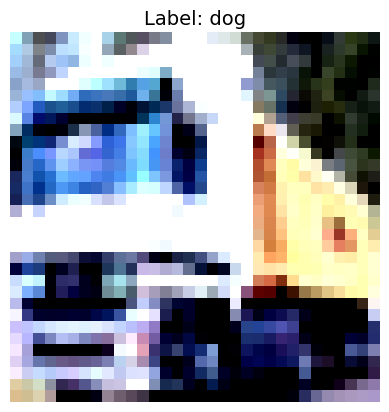

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transforms for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize with mean & std
])

# Load the CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to un-normalize and display the image with label
def imshow_with_label(img, label):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    
    # Add label to the image
    plt.title(f'Label: dog', fontsize=14, color='black')
    plt.axis('off')  # Hide axes
    plt.show()

# Get a random sample from the dataset
image, label = train_data[1]  # Replace 0 with any index to get a specific image

# Display the image with label on it
imshow_with_label(image, label)


## Define helper functions to be used during experiments

In [3]:
# This function evaluates a model's accuracy on the validation set
# Optionally, one can pass an adversarial patch as an argument to evaluate the model's performance against a patch attack
def eval(model, patch=None, target_class=None):
  # Stats to use to calculate accuracy after the eval loop
  total_correct = 0
  total = 0
  total_target = 0
  # Put model on GPU and switch to eval mode
  model = model.to(device)
  model.eval()
  # Evaluation loop
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      # Put data on GPU
      images = images.to(device)
      if patch is not None:
        images = apply(patch, images)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      predictions = torch.argmax(predictions, dim=1)
      # Update validation accuracy information
      total += len(images)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
      if target_class is not None:
        target = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
        num_target = (predictions == target).float().sum().item()
        total_target += num_target
  # If evaluating the effects of a targeted patch attach, it is nice to see whether or not the model is classifying lots of examples to the target class
  if target_class is not None:
    target_percentage = total_target / total
    print(f"Percentage of samples predicted as target class {target_class}: {100 * target_percentage}")
  # Calculate accuracy
  accuracy = total_correct / total
  return accuracy

In [4]:
# This function is designed to take in a pretrained ResNet model and fine-tune its weights for the CIFAR-10 dataset
# The idea is to fine-tune ResNet for the CIFAR-10 dataset (accuracy should be around 82%) and then degrade that performance via an adversarial patch attack
def fine_tune_for_cifar10(model, num_epochs=30, model_path="resnet34.pth", lr=0.01):
  # Put model on GPU and put model in training mode
  model = model.to(device)
  model.train()
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)
  best_accuracy = 0.0
  best_model_path = model_path
  # Training loop
  for i in range(num_epochs):
    # Stats to use for calculating accuracy
    total_correct = 0
    total = 0
    # Iterate through each batch of data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on GPU
      images = images.to(device)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      # Calculate loss for the batch
      loss = criterion(predictions, labels)
      # Gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Update training accuracy information
      total += len(images)
      predictions = torch.argmax(predictions, dim=1)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
    scheduler.step()  # Update the learning rate

    # Print training accuracy
    print(f"Epoch {str(i + 1)}: Training accuracy = {str(total_correct / total)}")
    # Print validation accuracy
    val_accuracy = eval(model, patch=None, target_class=None)
    print(f"Validation accuracy: {str(val_accuracy)}")

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved new best model with accuracy: {best_accuracy:.4f}")

In [5]:
# Apply patch to a batch of images
def apply(patch, batch_of_images):
  num_images = batch_of_images.shape[0]
  patch_size = patch.shape[1]
  # Iterate through each image in the batch
  for i in range(num_images):
    # Rotate the patch by a random number of degrees
    degree = random.uniform(0, 360)
    patch_rotated = TF.rotate(patch, angle=degree)
    # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
    # This coordinate will be where the top left corner of the rotated patch goes
    top_left_x = random.randint(0, 31 - patch_size)
    top_left_y = random.randint(0, 31 - patch_size)
    # Apply the randomly rotated patch at the random location
    batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch
  return batch_of_images

In [6]:
# Function to load the best model checkpoint
def load_model(model, path, device=device):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

In [7]:
# This function fine-tunes an adversarial patch against a provided whitebox model
# Model accuracy against the patch attack is reported at each step
def generate_adversarial_patch(model, patch_size, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply):
  model = model.to(device)
  model.eval()

  # Initialize patch to all zeros
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = optim.SGD([patch], lr, momentum)
  criterion = nn.CrossEntropyLoss()
  # Optimize the patch
  for i in range(num_epochs):
    print(f"Epoch {str(i + 1)}")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on the GPU
      images = images.to(device)
      labels = labels.to(device)
      # Apply the patch at a random location and with a random rotation for each image in the batch
      images = apply(patch, images)
      # Make predictions on the patched images
      predictions = resnet34(images)
      # For an untargeted attack, create false labels by incrementing the true labels by 1
      if target_class is None:
        false_labels = (labels + 1) % 10
      # For a targeted attack, set all the false labels to the target class
      else:
        false_labels = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
      # Tune the patch
      loss = criterion(predictions, false_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # See how the patch performs
    print(f"Target class: {target_class}")
    accuracy = eval(model, patch=patch, target_class=target_class)
    print(f"Accuracy: {str(accuracy)}\n")  
  return patch

In [8]:
# This function test the model accuracy on clean test dataset
# Optinally, if pass in an adversarial patch, this function test model accuracy, untargetted and targetted ASR
def test(model, patch=None, target_class=None, apply=apply):
  model.eval()
  total = 0
  total_correct = 0
  total_misclassified = 0
  total_targeted_hits = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      if patch is not None:
        images = apply(patch, images)

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      total_correct += (predictions == labels).sum().item()
      total_misclassified += (predictions != labels).sum().item()

      if target_class is not None:
        targeted_misclassifications = ((predictions != labels) & (predictions == target_class))
        total_targeted_hits += targeted_misclassifications.sum().item()

  adversarial_accuracy = total_correct / total
  untargeted_attack_rate = total_misclassified / total

  if patch is not None:
    print(f"Model accuracy with adversarial patch: {adversarial_accuracy * 100:.2f}%")
    print(f"Untargeted attack success rate on test set: {untargeted_attack_rate * 100:.2f}%")
  else:
    print(f"Model accuracy on clean test set: {adversarial_accuracy * 100:.2f}%")

  if target_class is not None:
    targeted_attack_rate = total_targeted_hits / total
    print(f"Targeted attack success rate on test set for class {target_class}: {targeted_attack_rate * 100:.2f}%")
    return adversarial_accuracy, untargeted_attack_rate, targeted_attack_rate
  else:
    return adversarial_accuracy, untargeted_attack_rate

In [9]:
# This function takes in a patch and outputs it visually
def visualize_patch(patch):
    patch = patch.detach()
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1]

    # Convert to numpy and transpose dimensions from [C, H, W] to [H, W, C] for visualization
    patch_np = patch.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(patch_np)
    plt.axis('off')
    plt.show()


In [10]:
# This function is used to plot the (untargeted or targeted) ASR v.s. patch size
def plot_asr_vs_patch_size(patch_sizes, asr_results):
    asr_values = [asr_results[size] * 100 for size in patch_sizes]
    plt.figure(figsize=(6,4))
    plt.plot(patch_sizes, asr_values, marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate vs Patch Size')
    plt.xlabel('Patch Size (pixels)')
    plt.ylabel('ASR (%)')
    plt.grid(True)
    plt.xticks(patch_sizes)
    plt.show()


## Fine-tune ResNet18 for CIFAR-10

In [12]:
# Load pre-trained model
from resnet import ResNet20
resnet34 = ResNet20()

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet34.linear = nn.Linear(resnet34.linear.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet34, num_epochs=30, model_path="resnet20.pth")

# Load best model checkpoint
resnet34 = load_model(resnet34, "resnet20.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet34, patch=None, target_class=None)

Epoch 1: Training accuracy = 0.391075
Validation accuracy: 0.4617
Saved new best model with accuracy: 0.4617
Epoch 2: Training accuracy = 0.49895
Validation accuracy: 0.5775
Saved new best model with accuracy: 0.5775
Epoch 3: Training accuracy = 0.596275
Validation accuracy: 0.6114
Saved new best model with accuracy: 0.6114
Epoch 4: Training accuracy = 0.6422
Validation accuracy: 0.6415
Saved new best model with accuracy: 0.6415
Epoch 5: Training accuracy = 0.68185
Validation accuracy: 0.6912
Saved new best model with accuracy: 0.6912
Epoch 6: Training accuracy = 0.710525
Validation accuracy: 0.7051
Saved new best model with accuracy: 0.7051
Epoch 7: Training accuracy = 0.736775
Validation accuracy: 0.7235
Saved new best model with accuracy: 0.7235
Epoch 8: Training accuracy = 0.750625
Validation accuracy: 0.7179
Epoch 9: Training accuracy = 0.768825
Validation accuracy: 0.7461
Saved new best model with accuracy: 0.7461
Epoch 10: Training accuracy = 0.778725
Validation accuracy: 0.7716

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 84.41%


(0.8441, 0.1559)

In [17]:
# Load pre-trained model
from resnet import ResNet10
resnet10 = ResNet10()

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet10.linear = nn.Linear(resnet10.linear.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet10, num_epochs=30, model_path="resnet10.pth")

# Load best model checkpoint
resnet10 = load_model(resnet10, "resnet10.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet10, patch=None, target_class=None)

Epoch 1: Training accuracy = 0.4042
Validation accuracy: 0.4947
Saved new best model with accuracy: 0.4947
Epoch 2: Training accuracy = 0.496575
Validation accuracy: 0.5359
Saved new best model with accuracy: 0.5359
Epoch 3: Training accuracy = 0.576075
Validation accuracy: 0.5955
Saved new best model with accuracy: 0.5955
Epoch 4: Training accuracy = 0.61515
Validation accuracy: 0.6114
Saved new best model with accuracy: 0.6114
Epoch 5: Training accuracy = 0.644975
Validation accuracy: 0.6577
Saved new best model with accuracy: 0.6577
Epoch 6: Training accuracy = 0.666875
Validation accuracy: 0.6784
Saved new best model with accuracy: 0.6784
Epoch 7: Training accuracy = 0.68295
Validation accuracy: 0.6778
Epoch 8: Training accuracy = 0.701375
Validation accuracy: 0.6936
Saved new best model with accuracy: 0.6936
Epoch 9: Training accuracy = 0.713625
Validation accuracy: 0.7274
Saved new best model with accuracy: 0.7274
Epoch 10: Training accuracy = 0.723875
Validation accuracy: 0.7133

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 80.78%


(0.8078, 0.1922)

In [18]:
# Load pre-trained model
from resnet import ResNet18
resnet18 = ResNet18()

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet18.linear = nn.Linear(resnet18.linear.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet18, num_epochs=30, model_path="resnet18.pth")

# Load best model checkpoint
resnet18 = load_model(resnet18, "resnet18.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Epoch 1: Training accuracy = 0.406325
Validation accuracy: 0.5202
Saved new best model with accuracy: 0.5202
Epoch 2: Training accuracy = 0.5202
Validation accuracy: 0.5906
Saved new best model with accuracy: 0.5906
Epoch 3: Training accuracy = 0.613225
Validation accuracy: 0.6215
Saved new best model with accuracy: 0.6215
Epoch 4: Training accuracy = 0.658075
Validation accuracy: 0.6831
Saved new best model with accuracy: 0.6831
Epoch 5: Training accuracy = 0.69155
Validation accuracy: 0.7054
Saved new best model with accuracy: 0.7054
Epoch 6: Training accuracy = 0.71595
Validation accuracy: 0.722
Saved new best model with accuracy: 0.7220
Epoch 7: Training accuracy = 0.73805
Validation accuracy: 0.7348
Saved new best model with accuracy: 0.7348
Epoch 8: Training accuracy = 0.75455
Validation accuracy: 0.7408
Saved new best model with accuracy: 0.7408
Epoch 9: Training accuracy = 0.76715
Validation accuracy: 0.7633
Saved new best model with accuracy: 0.7633
Epoch 10: Training accuracy

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 83.46%


(0.8346, 0.1654)

In [15]:
# Load best model checkpoint
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 10)
resnet34 = load_model(resnet34, "resnet34.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet34, patch=None, target_class=None)

/Users/hiepnguyen/Projects/590 Model Stealing/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiepnguyen/Projects/590 Model Stealing/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute

Model accuracy on clean test set: 77.46%


(0.7746, 0.2254)

In [19]:
# Load model architecture
from efficientNet import EfficientNetV2, efficientnet_v2_configs
model_variant = 'efficientnet_v2_s'  # Choose between 'efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l'
efficientv2s = EfficientNetV2(num_classes=10, architecture_config=efficientnet_v2_configs[model_variant]).to(device)

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18.linear = nn.Linear(resnet18.linear.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=efficientv2s, num_epochs=30, model_path="efficientv2s.pth")

# Load best model checkpoint
efficientv2s = load_model(efficientv2s, "efficientv2s.pth", device=device)

# Test model performance on clean test dataset
test(model=efficientv2s, patch=None, target_class=None)

Epoch 1: Training accuracy = 0.349975
Validation accuracy: 0.4549
Saved new best model with accuracy: 0.4549
Epoch 2: Training accuracy = 0.450875
Validation accuracy: 0.5104
Saved new best model with accuracy: 0.5104
Epoch 3: Training accuracy = 0.51555
Validation accuracy: 0.5579
Saved new best model with accuracy: 0.5579
Epoch 4: Training accuracy = 0.549075
Validation accuracy: 0.5825
Saved new best model with accuracy: 0.5825
Epoch 5: Training accuracy = 0.5779
Validation accuracy: 0.5937
Saved new best model with accuracy: 0.5937
Epoch 6: Training accuracy = 0.597975
Validation accuracy: 0.5907
Epoch 7: Training accuracy = 0.62
Validation accuracy: 0.6178
Saved new best model with accuracy: 0.6178
Epoch 8: Training accuracy = 0.6408
Validation accuracy: 0.6522
Saved new best model with accuracy: 0.6522
Epoch 9: Training accuracy = 0.6553
Validation accuracy: 0.6833
Saved new best model with accuracy: 0.6833
Epoch 10: Training accuracy = 0.672275
Validation accuracy: 0.6717
Epoch 

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 81.49%


(0.8149, 0.1851)

In [32]:
model_variant = 'efficientnet_v2_s'  # Choose between 'efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l'
testModel = EfficientNetV2(num_classes=10, architecture_config=efficientnet_v2_configs[model_variant]).to(device)
testModel = load_model(testModel, "efficientv2s.pth", device=device)
test(model=testModel, patch=None, target_class=None)

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 81.49%


(0.8149, 0.1851)

In [21]:
# Load model architecture
from efficientNet import EfficientNetV2, efficientnet_v2_configs
model_variant = 'efficientnet_v2_m'  # Choose between 'efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l'
efficientv2m = EfficientNetV2(num_classes=10, architecture_config=efficientnet_v2_configs[model_variant]).to(device)

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18.linear = nn.Linear(resnet18.linear.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=efficientv2m, num_epochs=30, model_path="efficientv2m.pth")

# Load best model checkpoint
efficientv2m = load_model(efficientv2m, "efficientv2m.pth", device=device)

# Test model performance on clean test dataset
test(model=efficientv2m, patch=None, target_class=None)

Epoch 1: Training accuracy = 0.263975
Validation accuracy: 0.3304
Saved new best model with accuracy: 0.3304
Epoch 2: Training accuracy = 0.335425
Validation accuracy: 0.3923
Saved new best model with accuracy: 0.3923
Epoch 3: Training accuracy = 0.4019
Validation accuracy: 0.4272
Saved new best model with accuracy: 0.4272
Epoch 4: Training accuracy = 0.4378
Validation accuracy: 0.4438
Saved new best model with accuracy: 0.4438
Epoch 5: Training accuracy = 0.473625
Validation accuracy: 0.4856
Saved new best model with accuracy: 0.4856
Epoch 6: Training accuracy = 0.5025
Validation accuracy: 0.5202
Saved new best model with accuracy: 0.5202
Epoch 7: Training accuracy = 0.525225
Validation accuracy: 0.5316
Saved new best model with accuracy: 0.5316
Epoch 8: Training accuracy = 0.550925
Validation accuracy: 0.5509
Saved new best model with accuracy: 0.5509
Epoch 9: Training accuracy = 0.56835
Validation accuracy: 0.5875
Saved new best model with accuracy: 0.5875
Epoch 10: Training accurac

/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_loc

Model accuracy on clean test set: 76.14%


(0.7614, 0.2386)

In [16]:
# Load best model checkpoint
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = load_model(resnet18, "resnet18x.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

/Users/hiepnguyen/Projects/590 Model Stealing/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiepnguyen/Projects/590 Model Stealing/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/_6/p9gp3zw14dzd_gfn0862fgg00000gn/T/ipykernel_32517/269044466.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute

Model accuracy on clean test set: 83.34%


(0.8334, 0.1666)

## Experiment 1: Untargeted 8x8 patch attack on ResNet18

In [ ]:
# Generate adversarial patch
patch_untargeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8)

# Visualize the generated patch
visualize_patch(patch_untargeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untargeted_size8)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 2: The effect of patch size on untargeted attack success rate for ResNet18

In [ ]:
# Calculate untargeteded ASR for patches of various sizes and plot patch size vs. untargeted ASR
patch_sizes = [3, 5, 7, 16]
untargetted_asr_results = {}

for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch)
  untargetted_asr_results[size] = untargetted_asr

plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 3: Targeted patch attacks

In [ ]:
# Generate targeted adversarial patch
patch_targeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5)

# Visualize the generated patch
visualize_patch(patch_targeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [15]:
def plot_targeted_asr_vs_patch_size(model, target_class):
  print(f"\nRUNNING EXPERIMENTS FOR TARGET CLASS {target_class}\n")
  patch_sizes = [3, 5, 7, 16]
  targetted_asr_results = {}
  for size in patch_sizes:
    patch = generate_adversarial_patch(model=model, patch_size=size, target_class=target_class)
    visualize_patch(patch)
    adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=target_class)
    targetted_asr_results[size] = targetted_asr
  plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

In [ ]:
for target_class in range(10):
  plot_targeted_asr_vs_patch_size(resnet18, target_class)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

## Experiment 4: Transferring patches to other models

In [ ]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet50, num_epochs=30, model_path="resnet50.pth")

# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO RESNET50")

# Untargeted Attack
test(model=resnet50, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=resnet50, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

### Test untarget & target attack on VGG19

In [ ]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")

# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth")

# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO VGG19")

# Untargeted Attack
test(model=vgg19, patch=patch_untargeted_size8, target_class=None)

# Targeted Attack
test(model=vgg19, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

### Test untarget & target attack on DenseNet121

In [ ]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
fine_tune_for_cifar10(model=densenet121, num_epochs=60, model_path="densenet121.pth",lr=0.05)

# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth")
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None)

print("\n------------------------------------------------------------------------------------\nTESTING PATCH TRANSFER FROM RESNET18 TO DENSENET121")

# Untargeted Attack
test(model=densenet121, patch=patch_untargeted_size8, target_class=None)
# Targeted Attack
test(model=densenet121, patch=patch_targeted_size8, target_class=5)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
from tabulate import tabulate

# Define the table data
table_data = [
    ["Model", "Model Accuracy", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8314, 0.6688, 0.7954],
    ["ResNet50", 0.8680, 0.5792, 0.1465],
    ["VGG19", 0.8843, 0.6252, 0.0892],
    ["DenseNet121", 0.7008, 0.5744, 0.0423]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


## Experiment 5: Creating patches that are robust to more transformations

In [30]:
# Apply patch to a batch of images with additional transformations (rotation, horizontal flip, vertical flip, color inversion)
def apply_extension(patch, batch_of_images):
    num_images = batch_of_images.shape[0]
    patch_size = patch.shape[1]

    # Iterate through each image in the batch
    for i in range(num_images):
        # Rotate the patch by a random number of degrees
        degree = random.uniform(0, 360)
        patch_rotated = TF.rotate(patch, angle=degree)

        # Apply horizontal flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.hflip(patch_rotated)

        # Apply vertical flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.vflip(patch_rotated)

        # Apply color inversion with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.invert(patch_rotated)

        # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
        # This coordinate will be where the top left corner of the rotated patch goes
        top_left_x = random.randint(0, 31 - patch_size)
        top_left_y = random.randint(0, 31 - patch_size)

        # Apply the randomly transformed patch at the random location
        batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch_rotated

    return batch_of_images


In [ ]:
# # Load pre-trained model
# resnet18ex = models.resnet18(weights="DEFAULT")

# # ResNet is trained on ImageNet, which has 1000 classes
# # So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18ex.fc = nn.Linear(resnet18ex.fc.in_features, 10)

# # Finetune the model
# fine_tune_for_cifar10(model=resnet18ex, num_epochs=30, model_path="resnet18ex.pth")
# # Load best model checkpoint
# resnet18ex = load_model(resnet18ex, "resnet18ex.pth", device=device)
# # Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

In [ ]:
# Generate adversarial patch
patch_untarget_ex = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_untarget_ex)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untarget_ex, target_class=None, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
# Generate adversarial patch
patch_target_ex = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_target_ex)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")
# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth", device=device)
# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=vgg19, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=vgg19, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
# fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth", device=device)
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=densenet121, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=densenet121, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=resnet50, patch=patch_untarget_ex, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=resnet50, patch=patch_target_ex, target_class=5, apply=apply_extension)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

In [ ]:
# Define the table data
table_data = [
    ["Model", "Model Accuracy", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8314, 0.6727, 0.3592],
    ["ResNet50", 0.8680, 0.5024, 0.2193],
    ["VGG19", 0.8843, 0.6930, 0.1035],
    ["DenseNet121", 0.7008, 0.5750, 0.1206]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. untargeted ASR.

In [ ]:
patch_sizes = [3, 5, 7, 10, 13, 16]
untargetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=None, num_epochs=10,\
                                      lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch, target_class=None, apply=apply_extension)
  untargetted_asr_results[size] = untargetted_asr
plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")

### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. targeted ASR. Target class is set to 5 here.

In [ ]:
patch_sizes = [3, 5, 7, 10, 13, 16]
targetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=5, num_epochs=10, \
                                     lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=5, apply=apply_extension)
  targetted_asr_results[size] = targetted_asr
plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

print("\n------------------------------------------------------------------------------------\n")
test(model=resnet18, patch=None, target_class=None)
print("\n------------------------------------------------------------------------------------\n")